# Calculate maintenance requirement and glucose yields for product and biomass

In this notebook we calculate the maintenance requirement $q_m$ and the yields $Y_{X/G}$ and $Y_{P/G}$, using a linear regression model.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import statsmodels.formula.api as smf
import pickle
import os
import collections

plt.rc('font', size=14)

for dir in ["data"]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [14]:
# collect parameters in dictionary for further use in models
parameter = dict()

In [15]:
t_max = 31  # latest time point used for analysis, the 35 h time point seems to have some unmodeled effects.

# load data
df = pd.read_csv('scripts/data/data.csv')
df['P'] = df.P_ccc / df.ccc_percent /10
df['X'] = df.X - df.P  # biomass data includs product
df = df[df.t <= t_max]
df_lin = df[df.feed == 'lin'].copy()

In [16]:
# calculate qG, qP and mu
experiments = list()
X0 = 1.52

for ex in df_lin.experiment.unique():
    x = df_lin[df_lin.experiment == ex]
    experiments.append(x)

values = list()
for x in experiments:
    t_av = (x.t.values [1:] + x.t.values[:-1]) / 2
    X_av = (x.X.values [1:] + x.X.values[:-1]) / 2
    dP = (x.P.values [1:] - x.P.values[:-1]) 
    dX = (x.X.values [1:] - x.X.values[:-1])
    dt = (x.t.values [1:] - x.t.values[:-1])
    mu = np.log(x.X.values[1:] / x.X.values[:-1]) / dt
    qP = dP / X_av / dt
    qG = 330 * 1 / (35*2) / X_av
    df_x = pd.DataFrame(np.array([t_av, X_av, mu, dP, dX, dt, qG, qP]).T, columns=['t_av', 'X_av', 'mu', 'dP', 'dX', 'dt', 'qG', 'qP']).set_index('t_av')
    df_x['starvation'] = x.starvation.values[1:]
    values.append(df_x)
    
df_all = pd.concat(values)
df_all['n'] = np.log2(df_all.X_av / X0)

df_growth = df_all[df_all.starvation == 'growth'].copy()

In [17]:
# save dateframes for late use
Dfs = collections.namedtuple('Dfs', 'all, growth, lin')

dfs = Dfs(df_all, df_growth, df_lin)

with open("data/flows.p", "wb") as f:
    pickle.dump(dfs, f)

In [18]:
# create linear model
results = smf.ols('qG ~ mu + qP', data=df_growth).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     qG   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     437.3
Date:                Wed, 12 Oct 2022   Prob (F-statistic):           2.21e-22
Time:                        12:45:37   Log-Likelihood:                 97.243
No. Observations:                  32   AIC:                            -188.5
Df Residuals:                      29   BIC:                            -184.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0989      0.004     24.489      0.000       0.091       0.107
mu             1.3848      0.104     13.315      0.000       1.172       1.598
qP             7.5790      1.384      5.474      0.000       4.747      10.411
==============================================================================
Omnibus:                        2.740   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                1.509
Skew:                          -0.459   Prob(JB):                        0.470
Kurtosis:                       3.536   Cond. No.                         645.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
conf_intervals = results.conf_int()
conf_intervals

,0,1
Intercept,0.090609,0.107123
mu,1.172120,1.597558
qP,4.747423,10.410507


In [20]:
parameter["Yxg"] = 1 / results.params.mu
print(
    f"Y_XG = {parameter['Yxg']} 95 % confidence interval [{1 / conf_intervals[1][1]}, {1 / conf_intervals[0][1]}]"
)


Y_XG = 0.7221056688105743 95 % confidence interval [0.6259555323860388, 0.8531548410128745]


In [21]:
parameter['Ypg'] = 1 / results.params.qP
print(
    f"Y_PG = {parameter['Ypg']} 95 % confidence interval [{1 / conf_intervals[1][2]}, {1 / conf_intervals[0][2]}]"
)

Y_PG = 0.13194413739432945 95 % confidence interval [0.09605680287178923, 0.21064058472661515]


In [22]:
parameter['qm'] = results.params.Intercept
print(
    f"qm = {parameter['qm']} 95 % confidence interval [{conf_intervals[0][0]}, {conf_intervals[1][0]}]"
)

qm = 0.09886616263035493 95 % confidence interval [0.09060921259014097, 0.10712311267056888]


In [23]:
with open('data/basic_parameters.p', 'wb') as file:
    pickle.dump(parameter, file)

The 3 dimensional model is not easy to plot. Therefore, we just plot the 2d model ignoring the influence of the product.

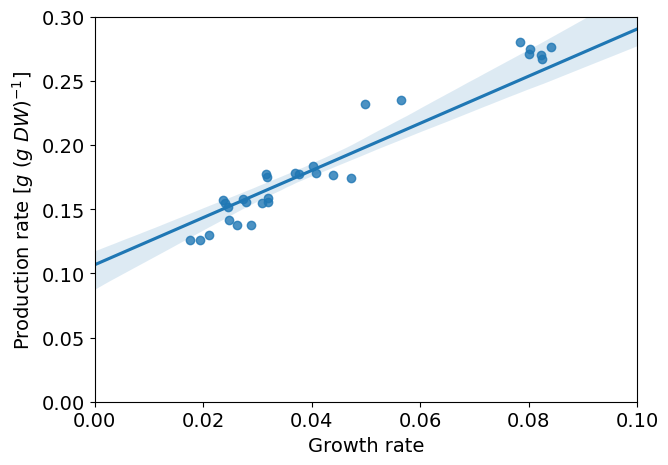

In [24]:
fig,ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.3)
seaborn.regplot(x=df_growth.mu, y=df_growth.qG, truncate=False)
ax.set_xlabel("Growth rate")
ax.set_ylabel("Production rate $[g \\ (g \\ DW)^{-1}]$")
plt.savefig("plots/yield_model.png", bbox_inches="tight")
plt.show()